# Objective
Clean data for case study of a prediction model that can be used to evaluate loan repayment behaviour of currently excluded customers of formal financial services
https://www.kaggle.com/c/home-credit-default-risk/data

# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from zipfile import ZipFile
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

### Create folder structure

In [3]:
# Make root folder the current working directory
os.chdir('..')

In [4]:
input_folder = './data/raw/'

In [5]:
cleaned_folder = './data/processed/basic/'

In [6]:
output_folder = './reports/figures/basic/'

## Data import

With the objective of creating a model that can be applied to the financially excluded, I deselected columns with data related to credit bureau, bank related data and formal loans.

The data dictionary can be found here:
https://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv

In [7]:
# Select columns which can be used by financially excluded
column_selection = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
                    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
                    'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
                    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                    'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
                    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
                    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                    'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                    'AMT_ANNUITY', 'AMT_GOODS_PRICE']

In [8]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
application_train_df = pd.read_csv(zip_file.open('application_train.csv'), usecols=column_selection)

In [9]:
# Remove outcome column from test data
column_selection.remove('TARGET')

In [10]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
application_test_df = pd.read_csv(zip_file.open('application_test.csv'), usecols=column_selection)

In [11]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
credit_card_df = pd.read_csv(zip_file.open('credit_card_balance.csv'), usecols=('SK_ID_CURR', 'NAME_CONTRACT_STATUS'))

In [12]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
bureau_df = pd.read_csv(zip_file.open('bureau.csv'), usecols=('SK_ID_CURR', 'CREDIT_ACTIVE'))

# Data cleaning

## General

In [13]:
# Merge test and train data for cleaning with column to distinguish
application_test_df['train'] = 0
application_train_df['train'] = 1
application_df = pd.concat([application_train_df, application_test_df]).reset_index(drop=True)

In [14]:
application_test_df = application_test_df.copy()

In [15]:
application_df.shape

(356255, 114)

## Select financially excluded

First step is to select unbanked customers to later evaluate that the ML model doesn't classify them as repayment risk. In the dataset there is no data available on whether the customer has a bank account, which is usually the first formal financial product people start using. Instead, we will be classifying someone as unbanked if there is no credit card or credit bureau information available.

In [272]:
ID_fin_included = list(credit_card_df['SK_ID_CURR']) + list(bureau_df['SK_ID_CURR'])
ID_fin_included = list(dict.fromkeys(ID_fin_included))

In [273]:
ID_all_applicants = application_train_df['SK_ID_CURR']
ID_fin_excluded = list(set(list(ID_all_applicants)) - set(ID_fin_included))
ID_fin_excluded_df = pd.DataFrame(ID_fin_excluded, columns=['SK_ID_CURR'])
ID_fin_included_df = pd.DataFrame(ID_fin_included, columns=['SK_ID_CURR'])

## Continuous variables

### Data transformations

In [18]:
# Log transform variables as per EDA
application_df['AMT_INCOME_TOTAL_log'] = np.log(application_df['AMT_INCOME_TOTAL'])
application_df['AMT_CREDIT_log'] = np.log(application_df['AMT_CREDIT'])
application_df['AMT_ANNUITY_log'] = np.log(application_df['AMT_ANNUITY'])
application_df['AMT_GOODS_PRICE_log'] = np.log(application_df['AMT_GOODS_PRICE'])

In [19]:
# Make negative values positive in preparation of log transformation
# Remove zero values by adding 1
application_df['DAYS_REGISTRATION'] = application_df['DAYS_REGISTRATION'] * -1 + 1
application_df['DAYS_REGISTRATION_log'] = np.log(application_df['DAYS_REGISTRATION'])

In [20]:
# Drop log transformed variables
cols_to_drop = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION']
application_df.drop(cols_to_drop, axis=1, inplace=True)

## Categorical data

In [21]:
application_df = application_df.copy()

### Outlier removal

In [22]:
# Recode organisation subcategories into one main category (eg 'Trade: type 6 -> 'Trade)
column = application_df['ORGANIZATION_TYPE']
types = ['Trade', 'Industry', 'Transport', 'Business']

for item in types:
    column.loc[column.str.startswith(item, na=False)] = item

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
# Create 'Other' category for categorical outliers
threshold = 0.01
df = application_df
for col in df[['ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE']]:
    value_counts = df[col].value_counts(normalize=True)
    below_threshold = value_counts[value_counts <= threshold].index.tolist()
    df[col].replace(to_replace=below_threshold, value="Other2", inplace=True)

In [26]:
# Remove rows with outlier categorical values
column_selection = list(application_df.select_dtypes(include=['object']))
threshold_percent = 0.01

for columns in column_selection:
    # Select rows falling below threshold
    rows_below_threshold = application_df[application_df[columns].map(application_df[columns].value_counts(normalize=True, dropna=False) < threshold_percent)]
    if len(rows_below_threshold.index) > 0:
        application_df.drop(rows_below_threshold.index, inplace=True)
    else:
        continue

## Missing data

In [27]:
# drop features with 50% or more missing data
missing_data = application_df.isna().sum() / application_df.isna().count() * 100
features_missing = list(missing_data[missing_data > 50].keys())
application_df.drop(features_missing, axis=1, inplace=True)

In [28]:
# Replace 'XNA' with the most frequent occuring gender response
freq = application_df['CODE_GENDER'].value_counts().index.tolist()[0]
application_df['CODE_GENDER'].replace('XNA', freq, inplace=False)
application_df['CODE_GENDER'].isna().sum()

0

In [29]:
# Calculate the missing data % in training data
missing = application_df.isna().sum() / application_df.isna().count() * 100
missing = missing[missing > 0]
missing

TARGET                      13.524264
OCCUPATION_TYPE             31.841687
TOTALAREA_MODE              49.748379
EMERGENCYSTATE_MODE         48.866047
OBS_30_CNT_SOCIAL_CIRCLE     0.294412
DEF_30_CNT_SOCIAL_CIRCLE     0.294412
OBS_60_CNT_SOCIAL_CIRCLE     0.294412
DEF_60_CNT_SOCIAL_CIRCLE     0.294412
DAYS_LAST_PHONE_CHANGE       0.000301
AMT_ANNUITY_log              0.010547
dtype: float64

In [30]:
# Drop cases with between 0-1% of missing data
df = application_df[application_df['train'] == 1]
minimal_missing = missing[(missing > 0) & (missing < 1)]
minimal_missing = list(minimal_missing.index)
df.dropna(axis=0, subset=minimal_missing, inplace=True)
print("Cases from the following columns were dropped:", minimal_missing)

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Cases from the following columns were dropped: ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY_log']


In [31]:
# Replace missing values in numerical columns with the median
num_columns = list(application_df.select_dtypes(include=['float64']).columns)
cols_nan = list(application_df[num_columns].columns[application_df[num_columns].isna().any()])
cols_nan.remove('TARGET')

for col in cols_nan:
    application_df[col].fillna(application_df[col].median(), inplace=True)

In [32]:
# Replace missing values in string+date columns with the mode
cols = list(application_df.select_dtypes(include=['O', 'object', 'datetime64']).columns)
cols_nan = list(application_df[cols].columns[application_df[cols].isna().any()])
cols_nan
for col in cols_nan:
    application_df[col].fillna(application_df[col].mode().iloc[0], inplace=True)

In [33]:
# Check remaining missing data % in training data
train_missing_data = application_df.isna().sum() / application_df.isna().count() * 100
train_missing_data[train_missing_data > 0]

TARGET    13.524264
dtype: float64

## Dummify categorical variables

In [34]:
application_df.shape

(331848, 68)

In [35]:
# Dummify categorical features
column_selection = list(application_df.select_dtypes(include=['object']))
# Create dummies of categorical features
application_df = pd.get_dummies(application_df, columns=column_selection, drop_first=True)

In [36]:
application_df.shape

(331848, 105)

# Feature creation

## Feature loan % of  income

In [37]:
application_df = application_df.copy()

In [38]:
application_df['creditVSincome_log'] = application_df['AMT_CREDIT_log'] / application_df['AMT_INCOME_TOTAL_log']

In [39]:
# Create a list of features
all_columns = list(application_df.columns)
no_feat = ['TARGET', 'SK_ID_CURR', 'train']
features = list(filter(lambda x: x not in no_feat, all_columns))

In [40]:
# assign y to dependent variable
y = application_df['TARGET']

In [41]:
absCorrWithDep = []

for var in features:
    absCorrWithDep.append(abs(y.corr(application_df[var])))

In [42]:
feature_scores_df = pd.DataFrame()
feature_scores_df['features'] = features
feature_scores_df['scores'] = absCorrWithDep

<AxesSubplot:>

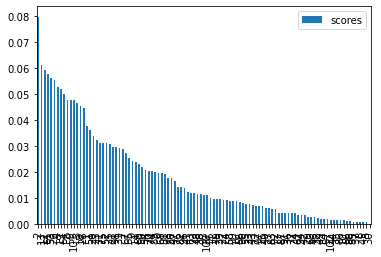

In [43]:
feature_scores_df = feature_scores_df.sort_values(by='scores', ascending=False)
feature_scores_df.plot.bar()

In [44]:
feature_scores_df.drop_duplicates(subset=['scores'], keep='first', inplace=True)

In [45]:
threshold = 0.04
feature_selection = list(feature_scores_df[feature_scores_df['scores'] > threshold]['features'])
len(feature_selection)

15

In [46]:
# Create final list with features and other required columns
column_selection = feature_selection + no_feat
application_df = application_df[column_selection]

# Standardise features

In [258]:
# Split test and train dataset
train_df = application_df[application_df['train'] == 1].copy()
test_df = application_df[application_df['train'] == 0].copy()

train_df.drop(columns=['train'], inplace=True)
test_df.drop(columns=['train'], inplace=True)

In [259]:
test_df.shape

(44880, 17)

In [260]:
# Split predictor and dependent variables
predictor = 'TARGET'
Y_train = train_df[predictor]
X_train = train_df.drop(predictor, axis=1)
test_df.drop(columns=predictor, inplace=True)

In [261]:
# Create numpy array of SK_ID_CURR to later use for submission file
test_ids_df = test_df['SK_ID_CURR']

In [262]:
# Drop ID column
test_df.drop(columns='SK_ID_CURR', inplace=True)
X_train.drop(columns='SK_ID_CURR', inplace=True)

In [263]:
# split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=10)

In [264]:
x_train = x_train.reset_index(drop=True).copy()
x_test = x_test.reset_index(drop=True).copy()

In [265]:
ss = StandardScaler()
num_features = ['DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
x_train[num_features] = pd.DataFrame(ss.fit_transform(x_train[num_features]))
x_test[num_features] = pd.DataFrame(ss.fit_transform(x_test[num_features]))

# Data export

In [274]:
# Export data to cleaned data folder
x_train.to_csv(cleaned_folder + 'x_train.csv', index=False)
x_test.to_csv(cleaned_folder + 'x_test.csv', index=False)
y_train.to_csv(cleaned_folder + 'y_train.csv', index=False)
y_test.to_csv(cleaned_folder + 'y_test.csv', index=False)
test_df.to_csv(cleaned_folder + 'test_df.csv', index=False)
test_ids_df.to_csv(cleaned_folder + 'test_ids_df.csv', index=False)
ID_fin_excluded_df.to_csv(cleaned_folder + 'IDs_fin_excluded.csv', index=False)
ID_fin_included_df.to_csv(cleaned_folder + 'ID_fin_included_df.csv', index=False)